In [255]:
import sys

import numpy as np
import pandas as pd

import ccbid
from ccbid import args
from ccbid import prnt


In [270]:
# if the ECODSE flag is set, override whatever is set at the command line
pt = "/Users/sergiomarconi/"
ainput = "NIS1_20140507_144927_atmcor_CNJRF.tif"
aitcput = "/Users/sergiomarconi/"+ainput[:-4]+".shp"
#ainput = args[1]
aremove_outliers = 'PCA'
athreshold = 3
aaggregate = 'average'
# args.feature_selection = False



In [273]:
# set the seed for reproducibility (to the year the CCB was founded)
np.random.seed(1984)
model = ccbid.read.pck("/Users/sergiomarconi/Documents/GitHub/ccb-id/model/ensemble")

# get base data from the model
sp_labels = model.labels_

In [274]:
from skimage import io
features = np.array(io.imread(pt+ainput))
npix = features.shape
features = features.flatten().reshape(npix[0]*npix[1], 369)
npix


(1000, 608, 369)

In [275]:
features

array([[  149,   153,   162, ...,   139,   162,   212],
       [  141,   154,   186, ...,   126,   188,   197],
       [  110,   165,   192, ...,   209,   189,   169],
       ...,
       [15000, 15000, 15000, ..., 15000, 15000, 15000],
       [15000, 15000, 15000, ..., 15000, 15000, 15000],
       [15000, 15000, 15000, ..., 15000, 15000, 15000]], dtype=int16)

In [276]:
from skimage import io
features = np.array(io.imread(pt+ainput))
npix = features.shape
features = features.flatten().reshape(npix[0]*npix[1], 369)

mask1 = np.all(features < 0, axis=1) | np.all(features > 10000, axis=1)
data = features[~mask1] / 10000
n_ok = data.shape


mask_pca = ccbid.outliers.with_pca(data, thresh=athreshold)
data = data[mask_pca, 24:369]
#id_labels = id_labels[mask]

data = model.reducer.transform(data)
data = data[:, 0:model.n_features_]
prnt.status("Applying CCBID model to input features")
prob = model.predict_proba(data, average_proba=True)

[ STATUS ] Applying CCBID model to input features


In [277]:
prob.shape

output = pd.DataFrame(index=range(mask_pca.shape[0]), columns=range(prob.shape[1]))
output.shape

(433476, 9)

In [278]:
output.loc[mask_pca,:] =  prob

In [279]:
final = pd.DataFrame(index=range(features.shape[0]), columns=range(prob.shape[1]))
final[~mask1] = output

In [280]:
# now get the itcs, and extract crowns average probabilities

In [281]:
#get the crown ids from the crown delinetation
import geopandas as gpd
import rasterio
from rasterio import features

itc = gpd.read_file(aitcput)

DriverError: /Users/sergiomarconi/NIS1_20140507_144927_atmcor_CNJRF.shp: No such file or directory

In [283]:
final = final.values.reshape(npix[0], npix[1], final.shape[1])

In [284]:
final.shape

(1000, 608, 9)

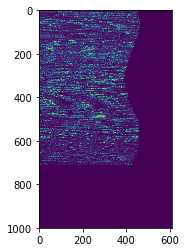

In [285]:
import matplotlib.pyplot as plt
img = final[:,:,1]
img[pd.isna(img)] = 0.0
plt.imshow(img.astype(float) )
plt.show()

In [216]:
with rasterio.open(ainput) as dataset:
    extent = dataset.transform
    data_crs = dataset.crs

In [269]:
for ii in range(prob.shape[1]):
    with rasterio.open("./polygons/rasters/"+ainput) as src:
        affine = src.transform
        array = src.read(ii+1)
        df_zonal_stats = pd.DataFrame(zonal_stats(itc, array, affine=affine, stats=['mean']))   

    #itc = pd.concat([itc, df_zonal_stats], axis=1)



RasterioIOError: ./polygons/rasters/NIS1_20140507_144927_atmcor_CNJRF.tif: No such file or directory

In [220]:
from rasterio.transform import from_origin
final = final.astype(float)

new_dataset = rasterio.open('test1.tif', 'w', driver='GTiff',
                            height = final.shape[0], width = final.shape[1],
                            count=prob.shape[1], dtype=str(final.dtype),
                            crs=data_crs,
                            transform=extent)

for ii in range(prob.shape[1]):
    tmp = final[:,:,ii].astype(float)
    new_dataset.write(tmp, ii+1)
new_dataset.close()


In [233]:
from rasterstats import zonal_stats
#get the crown ids from the crown delinetation
import geopandas as gpd
import rasterio
from rasterio import features

itc = gpd.read_file(aitcput)
itc.crs = data_crs

for ii in range(prob.shape[1]):
    with rasterio.open("./polygons/rasters/"+ainput) as src:
        affine = src.transform
        array = src.read(ii+1)
        df_zonal_stats = pd.DataFrame(zonal_stats(itc, array, affine=affine, stats=['mean']))

    # adding statistics back to original GeoDataFrame
    itc = pd.concat([itc, df_zonal_stats], axis=1) 

/Users/sergiomarconi/anaconda3/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/Users/sergiomarconi/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


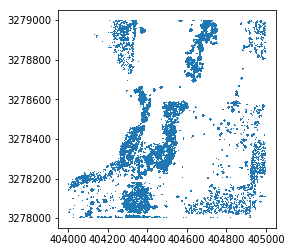

In [235]:
itc.plot()

In [236]:
itc.head()

,DN,geometry,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,22,"POLYGON ((404214 3278999, 404215 3278999, 4042...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,"POLYGON ((404276.5 3278999, 404279.5 3278999, ...",0.078934,0.069865,0.287013,0.018049,0.180826,0.032022,0.098878,0.178966,0.055447
2,4,"POLYGON ((404556.5 3278999, 404564 3278999, 40...",NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,"POLYGON ((404648 3278999, 404653 3278999, 4046...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,"POLYGON ((404671 3278999, 404678.5 3278999, 40...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [248]:
csv_name = "./predictions/polygons/"+ainput[:-4]
itc.dropna().to_csv(csv_name+".csv", index=False) 

In [244]:
ainput = "NIS1_20140507_144927_atmcor_CNJRF.tif"